# Reading the MNIST data set
The images from the data set have the size 28 x 28. They are saved in the csv data files mnist_train.csv and mnist_test.csv.

Every line of these files consists of an image, i.e. 785 numbers between 0 and 255.

The first number of each line is the label, i.e. the digit which is depicted in the image. The following 784 numbers are the pixels of the 28 x 28 image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
image_size = 28
no_of_different_labels = 10
image_pixels = image_size*image_size
data_path = "./MNIST/"
train_data = np.loadtxt(data_path + "mnist_train.csv", delimiter = ",")
test_data = np.loadtxt(data_path + "mnist_test.csv", delimiter = ",")


We map the values of the image data into the interval [0.01, 0.99] by dividing the train_data and test_data arrays by (255 * 0.99 + 0.01)

This way, we have input values between 0 and 1 but not including 0 and 1.

In [2]:
fac = 255*0.99 + 0.01
train_imgs = np.asfarray(train_data[:, 1:])/fac
test_imgs = np.asfarray(test_data[:, 1:])/fac
train_labels = np.asfarray(train_data[:, :1])
test_labels = np.asfarray(test_data[:, :1])


We need the labels in our calculations in a one-hot representation. We have 10 digits from 0 to 9, i.e. lr = np.arange(10).

Turning a label into one-hot representation can be achieved with the command: (lr==label).astype(np.int)

We demonstrate this in the following

In [4]:
import numpy as np
lr = np.arange(10)
for label in range(10):
    one_hot = (lr==label).astype(np.int)
    print("label: ", label, " in one_hot representation: ", one_hot)

label:  0  in one_hot representation:  [1 0 0 0 0 0 0 0 0 0]
label:  1  in one_hot representation:  [0 1 0 0 0 0 0 0 0 0]
label:  2  in one_hot representation:  [0 0 1 0 0 0 0 0 0 0]
label:  3  in one_hot representation:  [0 0 0 1 0 0 0 0 0 0]
label:  4  in one_hot representation:  [0 0 0 0 1 0 0 0 0 0]
label:  5  in one_hot representation:  [0 0 0 0 0 1 0 0 0 0]
label:  6  in one_hot representation:  [0 0 0 0 0 0 1 0 0 0]
label:  7  in one_hot representation:  [0 0 0 0 0 0 0 1 0 0]
label:  8  in one_hot representation:  [0 0 0 0 0 0 0 0 1 0]
label:  9  in one_hot representation:  [0 0 0 0 0 0 0 0 0 1]


We are ready now to turn our labelled images into one-hot representations. Instead of zeroes and one, we create 0.01 and 0.99, which will be better for our calculations:

In [6]:
lr = np.arange(no_of_different_labels)
# transform labels into one hot representation
train_labels_one_hot = (lr==train_labels).astype(np.float)
test_labels_one_hot = (lr==test_labels).astype(np.float)
# we don't want zeroes and ones in the labels neither:
train_labels_one_hot[train_labels_one_hot == 0] = 0.01
train_labels_one_hot[train_labels_one_hot == 0] = 0.99
test_labels_one_hot[test_labels_one_hot == 0] = 0.01
test_labels_one_hot[test_labels_one_hot == 1] = 0.99


Before we start using the MNIST data sets with our neural network, we will have a look at same images:



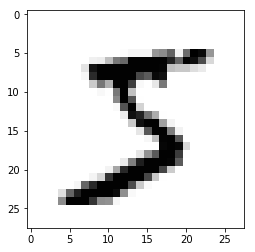

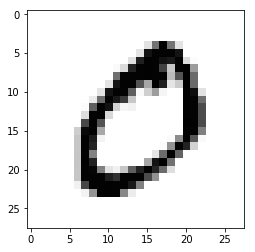

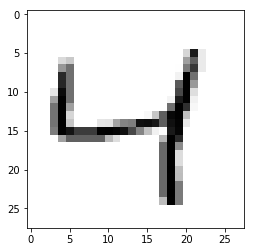

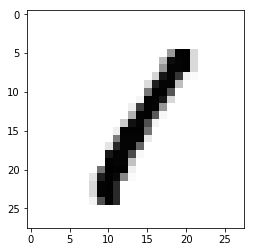

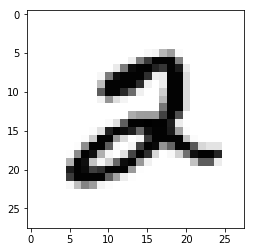

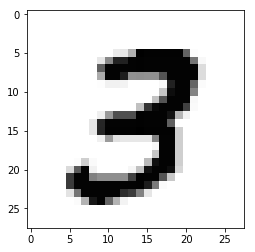

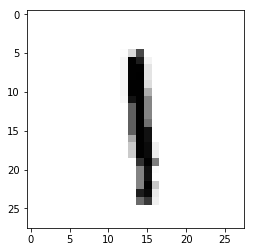

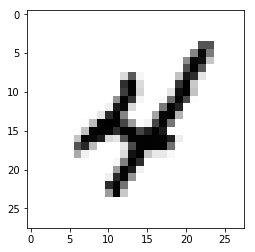

In [7]:
for i in range(10):
    img = train_imgs[i].reshape((28,28))
    plt.imshow(img, cmap="Greys")
    plt.show()

# Dumping the Data for Faster Reload
You may have noticed that it is quite slow to read in the data from the csv files.

We will save the data in binary format with the dump function from the pickle module:

In [11]:
import pickle
with open("./MNIST/pickle_mnist.pkl", "bw") as fh:
    data = (train_imgs, 
            test_imgs, 
            train_labels,
            test_labels,
            train_labels_one_hot,
            test_labels_one_hot)
    pickle.dump(data, fh)

We are able now to read in the data by using pickle.load. This is a lot faster than using loadtxt on the csv files:



In [12]:
import pickle
with open("./MNIST/pickle_mnist.pkl", "br") as fh:
    data = pickle.load(fh)
train_imgs = data[0]
test_imgs = data[1]
train_labels = data[2]
test_labels = data[3]
train_labels_one_hot = data[4]
test_labels_one_hot = data[5]
image_size = 28
no_of_different_labels =  10
image_pixels = image_size*image_size


# Classifying the Data
We will use the following neuronal network class for our first classification:



In [14]:
import numpy as np 

def sigmoid(x):
  return 1/(1+np.e**-x)
activation_function = sigmoid
from scipy.stats import truncnorm

def truncated_normal(mean=0, sd=1, low=0, upp=10):
  return truncnorm((low-mean)/sd,
    (upp-mean)/sd,
    loc=mean,
    scale=sd)


class NeuralNetwork:

  def __init__(self,
    no_of_in_nodes,
    no_of_out_nodes,
    no_of_hidden_nodes,
    learning_rate):
    self.no_of_in_nodes = no_of_in_nodes
    self.no_of_out_nodes = no_of_out_nodes
    self.no_of_hidden_nodes = no_of_hidden_nodes
    self.learning_rate = learning_rate
    self.create_weight_matrices()

  def create_weight_matrices(self):
    """
    A method to initialize the weight
    matrices of neural network
    """
    rad = 1/np.sqrt(self.no_of_in_nodes)
    x = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
    self.wih = x.rvs((self.no_of_hidden_nodes, self.no_of_in_nodes))
    rad = 1/np.sqrt(self.no_of_hidden_nodes)
    x = truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
    self.who = x.rvs((self.no_of_out_nodes, self.no_of_hidden_nodes))

  def train(self, input_vector, target_vector):
    """
    input_vector and target_vector can
    be tuple, list or ndarray
    """

    input_vector = np.array(input_vector, ndmin=2).T
    target_vector = np.array(target_vector, ndmin=2).T

    output_vector1 = np.dot(self.wih, input_vector)

    output_hidden = activation_function(output_vector1)

    output_vector2 = np.dot(self.who, output_hidden)

    output_network = activation_function(output_vector2)

    output_errors = target_vector - output_network

    # update the weights:
    tmp = output_errors*output_network*(1.0 - output_network)
    tmp = self.learning_rate*np.dot(tmp, output_hidden.T)
    self.who += tmp

    # Calculate hidden errors:
    hidden_errors = np.dot(self.who.T, output_errors)

    # Update the weights:
    tmp = hidden_errors*output_hidden*(1.0 - output_hidden)
    self.wih += self.learning_rate*np.dot(tmp, input_vector.T)

  def run(self, input_vector):
    # input can be tuple, list or ndarray
    input_vector = np.array(input_vector, ndmin=2).T
    output_vector = np.dot(self.wih, input_vector)
    output_vector = activation_function(output_vector)
    output_vector = np.dot(self.who, output_vector)
    output_vector = activation_function(output_vector)
    return output_vector

  def confusion_matrix(self, data_array, labels):
    cm = np.zeros((10, 10), int)
    for i in range(len(data_array)):
      res = self.run(data_array[i])
      res_max = res.argmax()
      target = labels[i][0]
      cm[res_max, int(target)] += 1
    return cm

  def precision(self, label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label]/col.sum()

  def recall(self, label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label]/row.sum()

  def evaluate(self, data, labels):
    corrects, wrongs = 0, 0
    for i in range(len(data)):
      res = self.run(data[i])
      res_max =res.argmax()
      if res_max == labels[i]:
        corrects += 1
      else:
        wrongs += 1
    return corrects, wrongs
#============================================================
ANN = NeuralNetwork(no_of_in_nodes = image_pixels,
  no_of_out_nodes = 10,
  no_of_hidden_nodes =100,
  learning_rate = 0.1)

for i in range(len(train_imgs)):
  ANN.train(train_imgs[i], train_labels_one_hot[i])

for i in range(20):
  res = ANN.run(test_imgs[i])
  print(test_labels[i], np.argmax(res), np.max(res))



[7.] 7 0.9905953977001136
[2.] 2 0.9765153494468677
[1.] 1 0.9881000665213852
[0.] 0 0.9886857076685415
[4.] 4 0.9565102367409157
[1.] 1 0.9891891161334467
[4.] 4 0.986595478861822
[9.] 9 0.9770410068633291
[5.] 6 0.31976519760073774
[9.] 9 0.9792691825919853
[0.] 0 0.9687532543516414
[6.] 6 0.8243320688960583
[9.] 9 0.9787459526645532
[0.] 0 0.9912362427745797
[1.] 1 0.9954585470165026
[5.] 5 0.9544631189619706
[9.] 9 0.9884246452328778
[7.] 7 0.9557548552151577
[3.] 3 0.5406114413602964
[4.] 4 0.9908560542403787


In [15]:
corrects, wrongs = ANN.evaluate(train_imgs, train_labels)
print("accuracy train: ", corrects/(corrects+wrongs))
corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accuracy test: ", corrects/(corrects+wrongs))
cm = ANN.confusion_matrix(train_imgs, train_labels)
print(cm)
for i in range(10):
  print("digit: ", i, "precision: ", ANN.precision(i, cm), "recall: ", ANN.recall(i, cm))
  

accuracy train:  0.94915
accuracy test:  0.9472
[[5811    3   55   27   11   50   41   16   14   30]
 [   0 6641   38   21   14   20   17   66   91   16]
 [   6   21 5513   62   10   12    2   44   10    2]
 [   5   23   69 5768    0   90    1   39   96   77]
 [   8   12   51    6 5491   30    6   39   35   70]
 [   9    5    4   79    2 5020   31    5   12    6]
 [  28    5   65   26   62   72 5790   10   39    4]
 [   1    5   38   22    4    6    0 5793    0   34]
 [  38   13  100   50    7   44   29   17 5428   16]
 [  17   14   25   70  241   77    1  236  126 5694]]
digit:  0 precision:  0.9810906635151105 recall:  0.9592274678111588
digit:  1 precision:  0.9850192821121329 recall:  0.9591276718659735
digit:  2 precision:  0.9253105068815038 recall:  0.9702569517775431
digit:  3 precision:  0.9407926928722884 recall:  0.9351491569390402
digit:  4 precision:  0.9399178363574119 recall:  0.9552887961029923
digit:  5 precision:  0.9260284080427965 recall:  0.9704233520201044
digit: 

# Multiple Runs
We can repeat the training multiple times. Each run is called an "epoch".

